In [1]:
import os
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dask.dataframe as dd
from tensorflow import keras
import tensorflow as tf
import tensorflow_probability as tfp

from matplotlib import font_manager, rc, dates
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

In [89]:
def reward_co2(co2):
    reward = np.exp(-((co2-900)**2)/(2*350**2))
    return reward

* 학습용 데이터셋 준비(솜사탕)

In [67]:
## 불러오기 ##
path = os.getcwd()
site_list = sorted(glob(os.path.join(path,"data","sensing_data","*")))
site_list = list(map(os.path.basename,site_list))
print(path)
print(site_list)
site = "솜사탕"
time_mean = "5T"
csv_by_site_det = []


structure = sorted(glob(os.path.join(path,"data","sensing_data",site,'*')))
structure = list(map(os.path.basename,structure))
for j in structure:
        temp_data = dd.read_csv(os.path.join(path,"data","sensing_data",site,j),encoding='cp949').compute()
        temp_data['T/D'] = pd.to_datetime(temp_data['T/D'])
       
        temp_data.set_index('T/D',inplace=True)
        temp_data = temp_data.resample(time_mean,).mean()
        temp_data['site_details'] = j
        csv_by_site_det.append(temp_data)

data = pd.concat(csv_by_site_det)
data.columns = ['index','temp','hum','pm1','pm2.5','pm4','pm10','co2','tvoc','site_details']
data = data[['temp','hum','pm1','pm2.5','pm4','pm10','co2','tvoc','site_details']]
## 라벨링 ##

data['vent'] = 0
data['people'] = 0

data.loc[data.between_time('12:00:00', '18:00:00',include_end=False).index,['vent']] = 1
data.loc[data.between_time('9:00:00', '16:00:00',include_end=False).index,['people']] = 1

#0부터 월요일
data.loc[data[data.index.dayofweek == 5].index,['vent']] = 0
data.loc[data[data.index.dayofweek == 5].index,['people']] = 0

data.loc[data[data.index.dayofweek == 6].index,['vent']] = 0
data.loc[data[data.index.dayofweek == 6].index,['people']] = 0



c:\Users\Go\OneDrive - UOS\allrepos\research_workspace\어린이집데이터_eda
['남부', '동화나라', '소리엘', '솜사탕', '예나']


In [74]:
room_list = ['솜사탕_거실.csv', '솜사탕_방1.csv','솜사탕_방2.csv','솜사탕_방3.csv','솜사탕_방4.csv','솜사탕_부엌.csv',]
data_by_room = {}
data_co2 = data.loc[:,['co2','site_details','vent','people']]

for i in room_list:
    room_name = i
    dataset = data_co2.loc[data_co2.site_details == room_name,:][['co2','vent','people']]

    dataset.loc[:,'co2_t+1'] = dataset.loc[:,'co2'].shift(-1)
    dataset.loc[:,'people_t+1'] = dataset.loc[:,'people'].shift(-1)
    dataset.loc[:,'reward'] = dataset.loc[:,'co2_t+1'].map(lambda x : reward_co2(x))
    dataset.loc[:,'done'] = False
    dataset.loc[dataset.between_time('00:00:00', '00:05:00',include_end=False).index,['done']] = True
    dataset = dataset.iloc[:-1,:]
    #데이터셋 추가
    data_by_room[i] = dataset.loc[:,:]



In [78]:
data_by_room[room_list[0]]

,co2,vent,people,co2_t+1,people_t+1,reward,done
T/D,,,,,,,
2021-12-30 12:10:00,1071.770429,1,1,NaN,1.0,NaN,False
2021-12-30 12:15:00,NaN,1,1,NaN,1.0,NaN,False
2021-12-30 12:20:00,NaN,1,1,NaN,1.0,NaN,False
2021-12-30 12:25:00,NaN,1,1,NaN,1.0,NaN,False
2021-12-30 12:30:00,NaN,1,1,NaN,1.0,NaN,False
...,...,...,...,...,...,...,...
2022-03-25 16:45:00,989.619533,1,0,1013.011067,0.0,0.949207,False
2022-03-25 16:50:00,1013.011067,1,0,1045.224733,0.0,0.917518,False
2022-03-25 16:55:00,1045.224733,1,0,1055.676833,0.0,0.905816,False


* 데이터 시계열 플롯

Wall time: 1.15 s


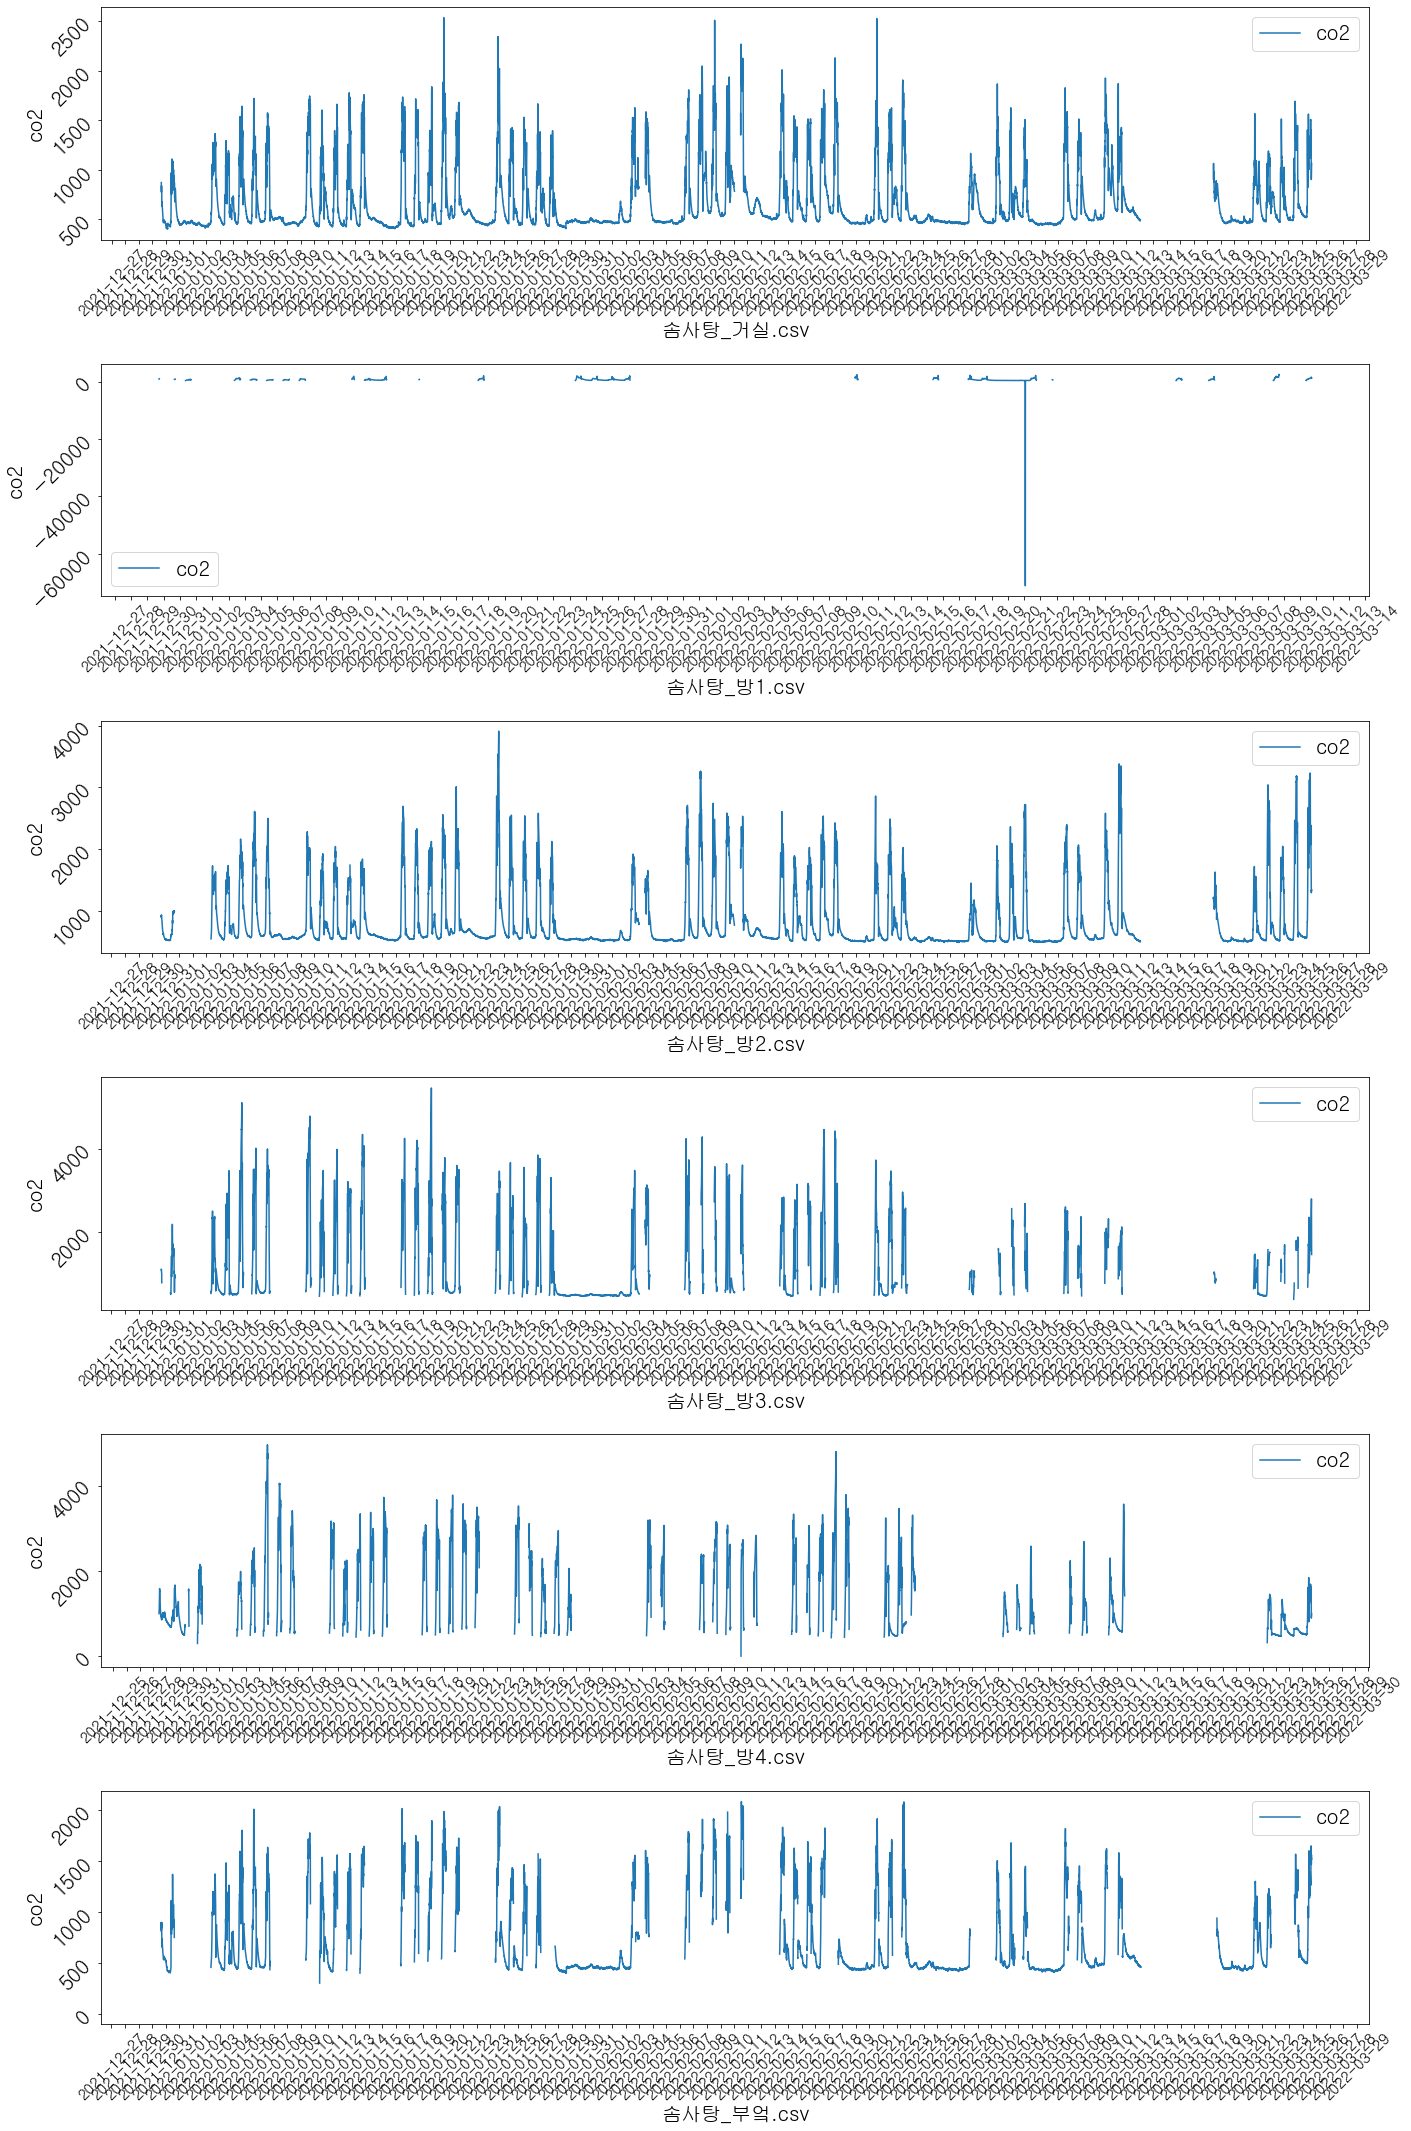

In [88]:
%%time
fig, axes = plt.subplots(len(room_list),1, figsize=(20,30))
# mean_by_date.loc[:,val].plot()
plt.rc('font', size=20)        # 기본 폰트 크기
# plt.rc('axes', labelsize=20)   # x,y축 label 폰트 크기
plt.rc('xtick', labelsize=15)  # x축 눈금 폰트 크기 
plt.rc('ytick', labelsize=20)  # y축 눈금 폰트 크기
plt.rc('legend', fontsize=20)  # 범례 폰트 크기
plt.rc('figure', titlesize=20)

for i, val in enumerate(room_list):
    p_data = data_by_room[val]

    axes[i].plot(p_data.loc[:,'co2'], label = 'co2')
    axes[i].set_ylabel('co2')
    axes[i].legend()
    axes[i].set_xlabel(val)
    axes[i].tick_params(labelrotation=45)
    axes[i].xaxis.set_major_locator(dates.DayLocator())
plt.tight_layout()

* 학습데이터 제작(쓸만한 데이터가 거실, 방2 밖에 없음), 방 4개 가정하고 거실,거실,방2,방2 데이터 사용
* ['2022-01-02':'2022-01-27'] 데이터 사용

In [90]:
data_by_room[val]

,co2,vent,people,co2_t+1,people_t+1,reward,done
T/D,,,,,,,
2021-12-30 12:15:00,14.284000,1,1,NaN,1.0,NaN,False
2021-12-30 12:20:00,NaN,1,1,NaN,1.0,NaN,False
2021-12-30 12:25:00,NaN,1,1,NaN,1.0,NaN,False
2021-12-30 12:30:00,NaN,1,1,NaN,1.0,NaN,False
2021-12-30 12:35:00,NaN,1,1,NaN,1.0,NaN,False
...,...,...,...,...,...,...,...
2022-03-25 15:45:00,1530.323533,1,1,1515.878367,1.0,0.212633,False
2022-03-25 15:50:00,1515.878367,1,1,1535.872233,1.0,0.191984,False
2022-03-25 15:55:00,1535.872233,1,1,1545.784667,0.0,0.182283,False
